In [1]:
!pip install -q fastbook

import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 3.6 MB/s 
     |████████████████████████████████| 189 kB 60.1 MB/s 
     |████████████████████████████████| 48 kB 4.8 MB/s 
     |████████████████████████████████| 1.2 MB 52.6 MB/s 
     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 561 kB 52.5 MB/s 
     |████████████████████████████████| 51 kB 290 kB/s 
     |████████████████████████████████| 130 kB 62.0 MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *

# 1. Data loading and augmentation

Create a DataBlock and DataLoaders using:
- Training and validation images collected in Lab2
- `Resize(640)` as item transform
- A size of 420 in the batch transforms
- Use a batch size of 32
- Use `set_seed()` to obtain reproducible results.
- Augmentations you find useful (see question 1)

Show a training and a validation batch.
Show augmentations, i.e. `show_batch()` with `unique=True`.

In [46]:
from fastai.vision.augment import warp
path = Path('/content/gdrive/MyDrive/Colab Notebooks/digits/')
set_seed(42, True)

digits = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(mult=0.8, do_flip=True, max_warp=0.4, p_lighting=0.5, flip_vert=True, size=420))

In [47]:
dls = digits.dataloaders(path, bs=32, seed=42)

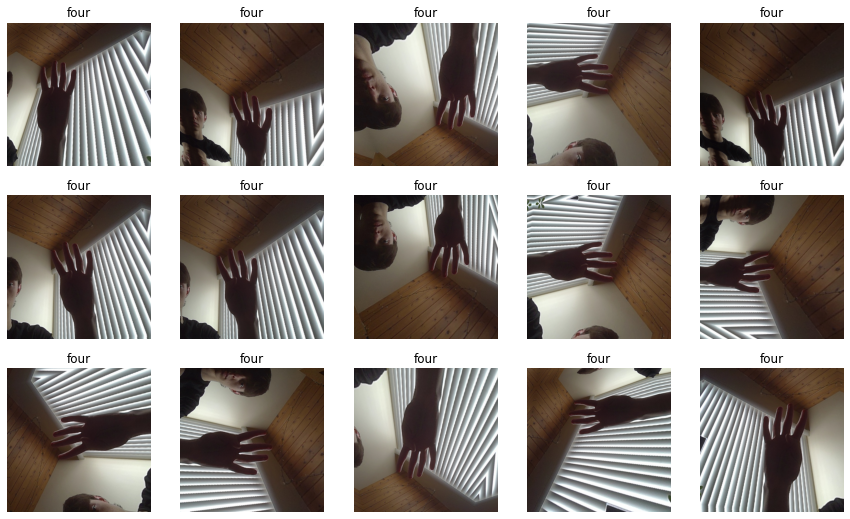

In [48]:
dls.train.show_batch(max_n=15, nrows=3, unique=True)

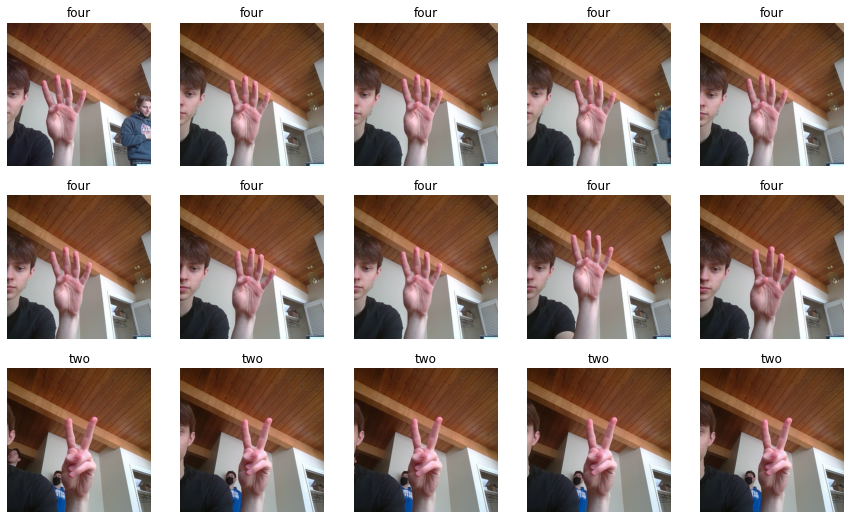

In [20]:
dls.valid.show_batch(max_n=15, nrows=3)

### Question 1: How did you choose your augmentation transfroms? Include your thought process.
When choosing the augmentation transforms, I felt like some of my data didn't have very much difference between each photo, so I wanted to warp and rotate in ways that made it more difficult to differeniate one photo from the next.

### Question 2: Are there any problems with your augmentations in the training data, or validation data, e.g. fingers missing, etc.?
Looking at the training and validation batches, there does not seem to be any visible problems with my chosen augmentations.


# 2. Train the classifier

## 2.1 Train a fastai cnn multi-class classifier
- ResNet18 architecture.
- accuracy as metric.
- learning rate finder to find initial learning rate.
- transfer learning with unfreezing using descriminative learning rates.
- use a batch size of 32 and the DataBlock from above.
- Use the same `set_seed()` as above to obtain reproducible results.

In [49]:
set_seed(42, True)
dls = digits.dataloaders(path,bs=32, seed=42)
learn = cnn_learner(dls, resnet18, metrics=accuracy)

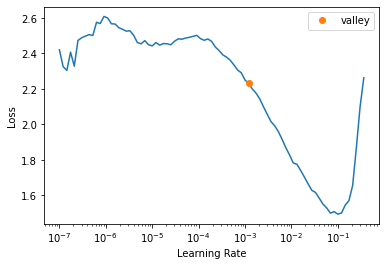

In [50]:
lr_valley = learn.lr_find()

In [51]:
lr_valley

SuggestedLRs(valley=0.0012022644514217973)

In [52]:
learn.fit_one_cycle(3, lr_valley)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.379806,3.085242,0.200000,00:06
1,2.036034,3.015120,0.140000,00:06
2,1.700817,3.226313,0.180000,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.973435,3.337795,0.200000,00:06
1,0.822555,3.219124,0.240000,00:06
2,0.747119,6.468641,0.460000,00:06
3,0.633977,7.937381,0.560000,00:06
4,0.568963,5.843952,0.500000,00:06
5,0.515545,7.727896,0.460000,00:06
6,0.442726,6.239637,0.600000,00:06
7,0.386862,7.371774,0.400000,00:06
8,0.339612,7.619777,0.400000,00:06
9,0.304477,6.849127,0.400000,00:06


### Question 3: How did you select the number of epochs and learning rates? 
I first ran 30 epochs and from there, chose the number of epochs with the best accuracy. I chose 12 because that was the number that yielded the best results. Based off the learning rate graph and the location of the valley, I chose learning rates between 1e-5 and 1e-2.


## 2.2 Experiment with different batch sizes
Using the pipeline, number of epochs, learning rates from above, re-run the pipeline with a batch size of 16, 64

In [28]:
for i in range(4,7):
  print('batch size: ', 2**i)
  set_seed(42, True)
  dls = digits.dataloaders(path, batch_size=2**i, seed=42)
  learn = cnn_learner(dls, resnet18, metrics=accuracy)

  learn.fit_one_cycle(4, lr_valley)

batch size:  16


epoch,train_loss,valid_loss,accuracy,time
0,2.232936,2.073364,0.080000,00:06
1,1.723888,2.578382,0.200000,00:06
2,1.484214,2.776984,0.220000,00:06
3,1.311751,2.798139,0.220000,00:06


batch size:  32


epoch,train_loss,valid_loss,accuracy,time
0,2.450977,2.114995,0.220000,00:06
1,1.879442,3.064888,0.140000,00:06
2,1.613888,3.761433,0.200000,00:06
3,1.468897,3.687896,0.200000,00:06


batch size:  64


epoch,train_loss,valid_loss,accuracy,time
0,2.595694,3.594162,0.200000,00:07
1,2.316943,3.455878,0.200000,00:07
2,1.967772,3.664896,0.100000,00:07
3,1.809174,3.534445,0.140000,00:07


### Question 4: Keeping number of epochs and learning rates the same, how are validation loss and accuracy effected by the increase and decrease of batch size? 
The larger the batch size, the slower and more consistent the improvement in the metrics is.


# 3. Analyze model performance
Retrain the model with batch size of 32 from the previous section.

Plot the confusion matrix.

In [30]:
set_seed(42, True)
dls = digits.dataloaders(path, bs=32, seed=42)
learn = cnn_learner(dls, resnet18, metrics=accuracy)

learn.fit_one_cycle(3, lr_valley)
learn.unfreeze
learn.fit_one_cycle(12, lr_valley)

epoch,train_loss,valid_loss,accuracy,time
0,2.410950,2.141042,0.200000,00:06
1,1.831896,2.986425,0.160000,00:06
2,1.611264,3.534968,0.200000,00:06


epoch,train_loss,valid_loss,accuracy,time
0,1.272416,3.640742,0.200000,00:06
1,1.076921,3.367337,0.220000,00:06
2,0.957003,3.282561,0.120000,00:06
3,0.867390,3.209299,0.220000,00:06
4,0.789975,3.042952,0.180000,00:06
5,0.744972,3.249753,0.200000,00:06
6,0.695254,3.090080,0.140000,00:06
7,0.651479,3.197300,0.160000,00:06
8,0.602898,3.231483,0.220000,00:06
9,0.545927,3.303882,0.220000,00:07


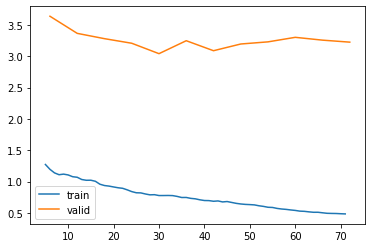

In [32]:
learn.recorder.plot_loss()

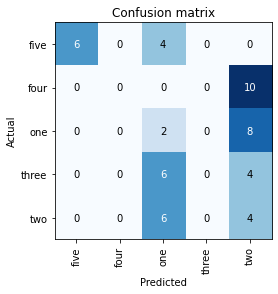

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# 4. Save the best model to file
Save the model using `learn.export()` as `.pkl` file. Verify that the model can be reloaded and used to make predictions.

In [34]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks/Lab3_model/')
if not(export_path).exists():
  export_path.mkdir()

  name = export_path/'digits_classifier.pkl'
  learn.export(fname=name)

# 5. Summary and Conclusion

Summarize:
- Augmentations used
- Training strategy, including batch size, number of epochs and learning rates.
- Accuracy achieved, summary of confusion matrix

## Conclusion
Augmentations used:
- mult=0.8, do_flip=True, max_warp=0.5, p_lighting=0.5, flip_vert=True

Training Strategy:
- batch_size=32, no. of epochs=12, learning rate = 0.0012

Accuracy achieved:
The max accuracy achieved was 0.60. The confusion matrix was alright, but the model kept guessing two in place for four, which is not ideal.


Conclusion:
- Are you satisfied with model performance? Why, why not?

I am somewhat satisfied with the model's performance. I would've like to see the mode perform better than an accuracy of 0.60, but after testing various learning rates and number of epochs, I was unsuccessful in achieving a higher performance accuracy.




# 6.Reflection
Include a sentence or two about
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating

while working on this assignment.

What I liked most about this lab was being able to apply our knowledge on how to improve the models that we create and test. Being able to work with the parameters and finding the best results was interesting to see, but also slightly challenging, as finding a good accuracy was not always possible.
